# Modified code for Homework Assignment 4
_____________________
by Matlotlo Dhlamini

## Week 4 Practicals

## Part 1: Spatial Estimation with Inverse Distance


### Prof. Glen Nwaila and Dr Steven Zhang (Adapted from Prof. Michael Pyrcz)



#### Spatial Estimation

Consider the case of making an estimate at some unsampled location, $𝑧(\bf{u}_0)$, where $z$ is the property of interest (e.g. porosity etc.) and $𝐮_0$ is a location vector describing the unsampled location.

How would you do this given data, $𝑧(\bf{𝐮}_1)$, $𝑧(\bf{𝐮}_2)$, and $𝑧(\bf{𝐮}_3)$?

It would be natural to use a set of linear weights to formulate the estimator given the available data.

\begin{equation}
z^{*}(\bf{u}) = \sum^{n}_{\alpha = 1} \lambda_{\alpha} z(\bf{u}_{\alpha})
\end{equation}

We could add an unbiasedness constraint to impose the sum of the weights equal to one.  What we will do is assign the remainder of the weight (one minus the sum of weights) to the global average; therefore, if we have no informative data we will estimate with the global average of the property of interest.

\begin{equation}
z^{*}(\bf{u}) = \sum^{n}_{\alpha = 1} \lambda_{\alpha} z(\bf{u}_{\alpha}) + \left(1-\sum^{n}_{\alpha = 1} \lambda_{\alpha} \right) \overline{z}
\end{equation}

We will make a stationarity assumption, so let's assume that we are working with residuals, $y$.

\begin{equation}
y^{*}(\bf{u}) = z^{*}(\bf{u}) - \overline{z}(\bf{u})
\end{equation}

If we substitute this form into our estimator the estimator simplifies, since the mean of the residual is zero.

\begin{equation}
y^{*}(\bf{u}) = \sum^{n}_{\alpha = 1} \lambda_{\alpha} y(\bf{u}_{\alpha})
\end{equation}

while satisfying the unbaisedness constraint.  

#### Inverse Distance

Now the next question is what weights should we use?  

We could use inverse distance weighting, $\lambda = \frac{1}{(d_{0,\alpha})^p} \forall \alpha = 1,\ldots,n$, where $0$ is the unknown location and there are $n$ local data available to support the estimate.   

#### Getting Started

Here's the steps to get setup in Python with the GeostatsPy package:

1. Install Anaconda 3 on your machine (https://www.anaconda.com/download/).
2. From Anaconda Navigator (within Anaconda3 group), go to the environment tab, click on base (root) green arrow and open a terminal.
3. In the terminal type: pip install geostatspy.
4. Open Jupyter and in the top block get started by copy and pasting the code block below from this Jupyter Notebook to start using the geostatspy functionality.


#### Load the required libraries

The following code loads the required libraries.

In [9]:
!pip install geostatspy

In [10]:
import geostatspy.GSLIB as GSLIB                       # GSLIB utilies, visualization and wrapper
import geostatspy.geostats as geostats                 # GSLIB methods convert to Python

We will also need some standard packages. These should have been installed with Anaconda 3.

In [11]:
import os                                               # to set current working directory
import numpy as np                                      # arrays and matrix math
import pandas as pd                                     # DataFrames
import matplotlib.pyplot as plt                         # plotting

If you get a package import error, you may have to first install some of these packages. This can usually be accomplished by opening up a command window on Windows and then typing 'python -m pip install [package-name]'. More assistance is available with the respective package docs.  


#### Set the working directory

I always like to do this so I don't lose files and to simplify subsequent read and writes (avoid including the full address each time).  Also, in this case make sure to place the required (see above) GSLIB executables in this directory or a location identified in the environmental variable *Path*.

In [12]:
current_directory = os.getcwd()                                   # set the working directory
current_directory

'/content'

# Question 1: Directory Creation

In [13]:
# Reading data option 1
##warnings.filterwarnings("ignore")
##current_path = os.getcwd()


# Set the path for the images directory
image_path = 'Images'
results_path = 'Results'

# Check if the images directory already exists
if not os.path.exists(image_path):
    # Create the images directory
    os.mkdir(image_path)
else:
    print('Image directory already exists')

# Check if the file directory already exists
if not os.path.exists(results_path):
    # Create the file directory
    os.mkdir(results_path)
else:
    print('File directory already exists')

print('Image directory is -', image_path)
print('File directory is -', results_path)

Image directory already exists
File directory already exists
Image directory is - Images
File directory is - Results


#### Loading Tabular Data

Here's the command to load our comma delimited data file in to a Pandas' DataFrame object.

In [14]:
df = pd.read_csv(current_directory+"/sample_data_MV_biased.csv")                     # read a .csv file in as a DataFrame
df.head()                                               # we could also use this command for a table preview

,Unnamed: 0,X,Y,Facies,Porosity,Perm,AI
0,0,100.0,900.0,0.0,0.101319,1.996868,5590.417154
1,1,100.0,800.0,1.0,0.147676,10.711789,3470.845666
2,2,100.0,700.0,1.0,0.145912,17.818143,3586.988513
3,3,100.0,600.0,1.0,0.186167,217.109365,3732.114787
4,4,100.0,500.0,1.0,0.146088,16.717367,2534.551236


Let's look at summary statistics for all facies combined:

In [15]:
df.describe().transpose()                          # summary table of all facies combined DataFrame statistics

,count,mean,std,min,25%,50%,75%,max
Unnamed: 0,368.0,293.260870,169.058258,0.000000,150.500000,296.000000,439.500000,586.000000
X,368.0,499.565217,289.770794,0.000000,240.000000,500.000000,762.500000,990.000000
Y,368.0,520.644022,277.412187,9.000000,269.000000,539.000000,769.000000,999.000000
Facies,368.0,0.597826,0.491004,0.000000,0.000000,1.000000,1.000000,1.000000
Porosity,368.0,0.127026,0.030642,0.041122,0.103412,0.125842,0.148623,0.210258
Perm,368.0,85.617362,228.362654,0.094627,2.297348,10.377292,50.581288,1991.097723
AI,368.0,4791.736646,974.560569,1981.177309,4110.728374,4713.325533,5464.043562,7561.250336


Let's also look at the distributions.  

# Question 2: Saving Images

In [16]:
# A function to save a figure in both PNG and PDF formats at 300 DPI
def save_fig(fig, filename):
    # Making sure the directory exists
    if not os.path.exists(image_path):
        os.makedirs(image_path)

    # Path for the PNG and PDF files
    png_path = os.path.join(image_path, f"{filename}.png")
    pdf_path = os.path.join(image_path, f"{filename}.pdf")

    # Save the figure in PNG format
    fig.savefig(png_path, format='png', dpi=300)

    # Save the figure in PDF format
    fig.savefig(pdf_path, format='pdf', dpi=300)

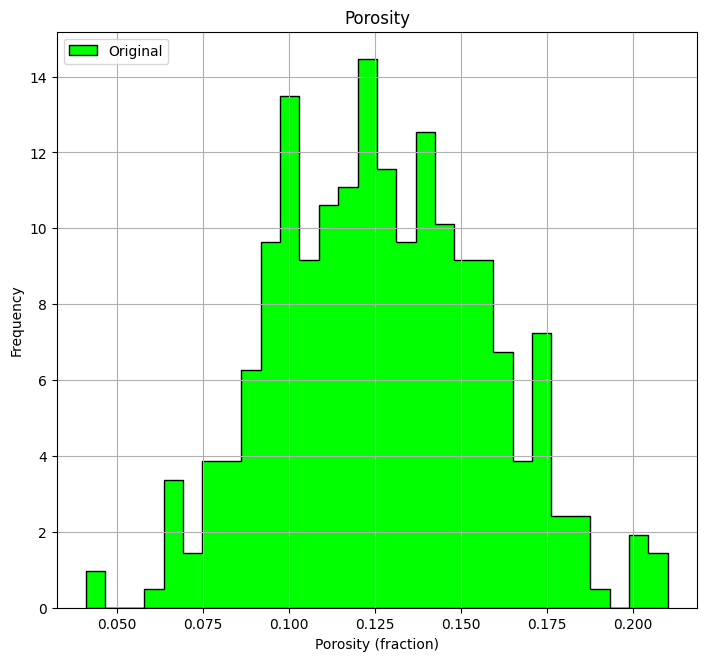

In [17]:
plt.subplot(111)                                        # plot original sand and shale porosity histograms
fig_1 = plt.hist(df['Porosity'], facecolor='lime',bins=30,histtype="stepfilled",alpha=1,density=True,cumulative=False,edgecolor='black',label='Original')

plt.xlabel('Porosity (fraction)'); plt.ylabel('Frequency'); plt.title('Porosity')
plt.legend(loc='upper left')
plt.grid(True)

plt.subplots_adjust(left=0.0, bottom=0.0, right=1.0, top=1.2, wspace=0.2, hspace=0.3)

fig_1 = plt.gcf()  # Get the current figure before calling plt.show()

plt.show()

## Save the fig to the Image directory:
save_fig(fig_1, 'Porosity_Hist')

We can observe from the CDFs that the porosity distribution is 'Gaussian-like' in shape, while the permeability distribution is 'lognormal-like'.  They both look well behaved.

For brevity we will omit data declustering from this workflow. We will assume declustered means for the porosity and permeability to apply with simple kriging.

Let's plot the location maps of porosity and permeability for all facies. We will also include a cross plot of permeability vs. porosity colored by facies to aid with comparison in spatial features between the porosity and permeability data.

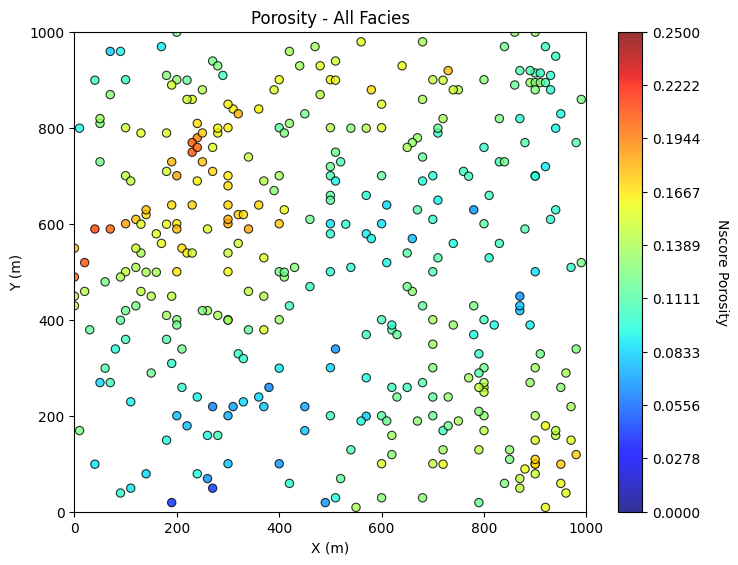

In [18]:
cmap = plt.cm.jet                   # color map
plt.subplot(111)
GSLIB.locmap_st(df,'X','Y','Porosity',0,1000,0,1000,0,0.25,'Porosity - All Facies','X (m)','Y (m)','Nscore Porosity',cmap)

plt.subplots_adjust(left=0.0, bottom=0.0, right=1.0, top=1.0, wspace=0.5, hspace=0.3)

fig_2 = plt.gcf()  # Get the current figure before calling plt.show()

plt.show()

save_fig(fig_2, 'Porosity_All_Facies')

#### Inverse Distance

To demonstrate inverse distance, we include a inverse distance function.  

* it is a modification of the 2D kriging program in GeostatsPy

In [19]:
import numpy as np
import scipy.spatial as sp

def invdist(df, xcol, ycol, vcol, tmin, tmax, nx, xmn, xsiz, ny, ymn, ysiz, ndmin, ndmax, radius, power):
    """
    Inverse Distance to Python by Michael Pyrcz, the University of Texas at
    Austin (April, 2020). Based on modification of the GSLIB kb2d program by Deutsch and Journel (1997)

    :param df: pandas DataFrame with the spatial data
    :param xcol: name of the x coordinate column
    :param ycol: name of the y coordinate column
    :param vcol: name of the property column
    :param tmin: property trimming limit
    :param tmax: property trimming limit
    :param nx: definition of the grid system (x axis)
    :param xmn: definition of the grid system (x axis)
    :param xsiz: definition of the grid system (x axis)
    :param ny: definition of the grid system (y axis)
    :param ymn: definition of the grid system (y axis)
    :param ysiz: definition of the grid system (y axis)
    :param ndmin: minimum number of data points to use for kriging a block
    :param ndmax: maximum number of data points to use for kriging a block
    :param radius: maximum isotropic search radius
    :param power: the inverse distance power
    :return: estmap, an array with estimated values at each grid cell
    """
    # Constants
    UNEST = -999.
    EPSILON = 1.0e-10

    # Load the data
    df_extract = df.loc[(df[vcol] >= tmin) & (df[vcol] <= tmax)]  # Trim values outside tmin and tmax
    nd = len(df_extract)
    ndmax = min(ndmax, nd)
    x = df_extract[xcol].values
    y = df_extract[ycol].values
    vr = df_extract[vcol].values

    # Allocate the needed memory:
    xa = np.zeros(ndmax)
    ya = np.zeros(ndmax)
    vra = np.zeros(ndmax)
    dist = np.zeros(ndmax)
    nums = np.zeros(ndmax)
    s = np.zeros(ndmax)
    estmap = np.zeros((nx, ny))

    # Make a KDTree for fast search of nearest neighbors
    data_locs = np.column_stack((y, x))
    tree = sp.cKDTree(data_locs, leafsize=16, compact_nodes=True, copy_data=False, balanced_tree=True)

    # Summary statistics for the data after trimming
    avg = vr.mean()
    stdev = vr.std()
    ss = stdev**2.0
    vrmin = vr.min()
    vrmax = vr.max()

    # Initialize accumulators
    rad2 = radius**2

    # MAIN LOOP OVER ALL THE BLOCKS IN THE GRID
    nk = 0
    ak = 0.0
    vk = 0.0
    for iy in range(0, ny):
        yloc = ymn + (iy - 0) * ysiz
        for ix in range(0, nx):
            xloc = xmn + (ix - 0) * xsiz
            current_node = (yloc, xloc)

            # Find the nearest samples within each octant: First initialize the counter arrays
            na = -1  # Accounting for 0 as the first index
            dist.fill(1.0e+20)
            nums.fill(-1)
            dist, nums = tree.query(current_node, ndmax)  # Use KD tree for fast nearest data search

            # Remove any data outside search radius
            nums = nums[dist < radius]
            dist = dist[dist < radius]
            nd = len(dist)

            # Is there enough samples?
            if nd < ndmin:  # Accounting for min index of 0
                est = UNEST
            else:
                # Put coordinates and values of neighborhood samples into xa, ya, vra
                for ia in range(0, nd):
                    jj = int(nums[ia])
                    xa[ia] = x[jj]
                    ya[ia] = y[jj]
                    vra[ia] = vr[jj]

                # Solve for weights
                dist = np.sqrt((xa - xloc)**2 + (ya - yloc)**2)
                s = 1 / ((dist + EPSILON)**power)  # Calculate inverse weights
                s = s / np.sum(s)  # Constrain sum of the weights to 1.0 for unbiasedness
                est = 0.0
                for ia in range(0, nd):
                    est = est + s[ia] * vra[ia]

            estmap[ny - iy - 1, ix] = est

            # Track the estimates
            if est > UNEST:
                nk = nk + 1
                ak = ak + est
                vk = vk + est**2

    # END OF MAIN LOOP OVER ALL THE BLOCKS

    if nk >= 1:
        ak = ak / float(nk)
        vk = vk / float(nk) - ak**2
        print('Estimated ' + str(nk) + ' blocks')
        print('Average ' + str(ak) + '  Variance ' + str(vk))

    return estmap


#### Simple Test at Single Location

Let's test the method for a single estimation location.

* the result was validated with by-hand calculation for inside range, outside range and collocated with a data point

In [20]:
x = [100,600,800]; y = [100,500,700]; vr = [1.0,2.0,3.0]
dftest1 = pd.DataFrame({'X':x,'Y':y,'Var':vr})
tmin = -9999.9; tmax = 9999.9;
nx = 1; xsiz = 10.0; xmn = 500
ny = 1; ysiz = 10.0; ymn = 500
ndmin = 1; ndmax = 100
radius = 1000.0; power = 2

invdist_est = invdist(dftest1,'X','Y','Var',tmin,tmax,nx,xmn,xsiz,ny,ymn,ysiz,ndmin,ndmax,radius,power)
print('The single estimate at x = ' + str(xmn) + ', y = ' + str(ymn) + ' is ' + str(invdist_est[0][0]) + '.')

Estimated 1 blocks
Average 2.041214750542347  Variance 0.0
The single estimate at x = 500, y = 500 is 2.041214750542347.


#### Build a Estimation Map

Now we check the method by building maps with 3 different powers

Estimated 10000 blocks
Average 2.4785256874279527  Variance 0.18122365890746384
Estimated 10000 blocks
Average 2.4797288690464803  Variance 0.5062609912988218
Estimated 10000 blocks
Average 2.4893068152705276  Variance 0.7378534388298741


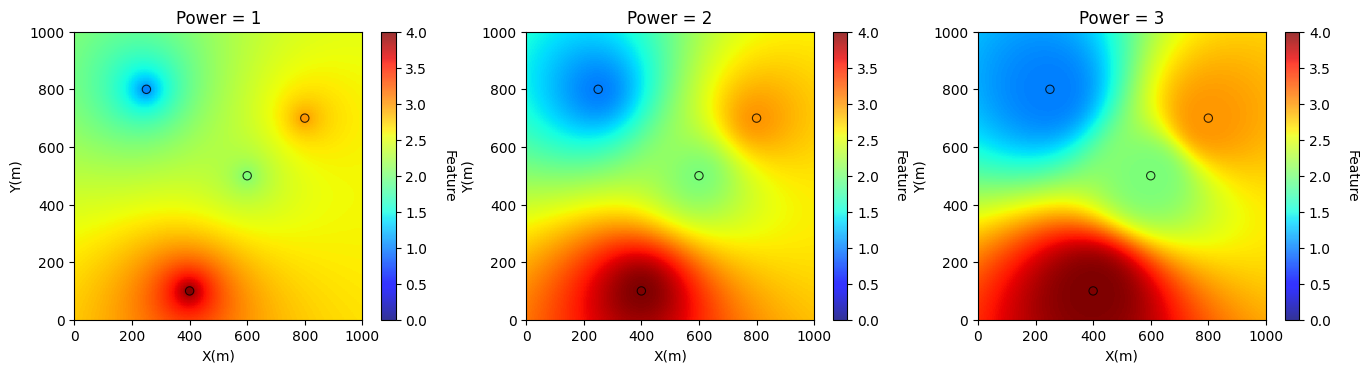

In [21]:
x = [250,600,800,400]; y = [800,500,700,100]; vr = [1.0,2.0,3.0,4.0]
dftest2 = pd.DataFrame({'X':x,'Y':y,'Var':vr})
tmin = -9999.9; tmax = 9999.9;
nx = 100; xsiz = 10.0; xmn = 5.0; xmin = xmn - 0.5 * xsiz; xmax = xmin + nx * xsiz
ny = 100; ysiz = 10.0; ymn = 5.0; ymin = ymn - 0.5 * ysiz; ymax = ymin + ny * ysiz
ndmin = 1; ndmax = 100
radius = 10000.0; power = 2

invdist_map_power1 = invdist(dftest2,'X','Y','Var',tmin,tmax,nx,xmn,xsiz,ny,ymn,ysiz,ndmin,ndmax,radius,power=1)
invdist_map_power2 = invdist(dftest2,'X','Y','Var',tmin,tmax,nx,xmn,xsiz,ny,ymn,ysiz,ndmin,ndmax,radius,power=2)
invdist_map_power3 = invdist(dftest2,'X','Y','Var',tmin,tmax,nx,xmn,xsiz,ny,ymn,ysiz,ndmin,ndmax,radius,power=3)

# plot the reuslting estimated maps
plt.subplot(131)
GSLIB.locpix_st(invdist_map_power1,xmin,xmax,ymin,ymax,xsiz,0.0,4.0,dftest2,'X','Y','Var','Power = 1','X(m)','Y(m)','Feature',cmap)

plt.subplot(132)
GSLIB.locpix_st(invdist_map_power2,xmin,xmax,ymin,ymax,xsiz,0.0,4.0,dftest2,'X','Y','Var','Power = 2','X(m)','Y(m)','Feature',cmap)

plt.subplot(133)
GSLIB.locpix_st(invdist_map_power3,xmin,xmax,ymin,ymax,xsiz,0.0,4.0,dftest2,'X','Y','Var','Power = 3','X(m)','Y(m)','Feature',cmap)

plt.subplots_adjust(left=0.0, bottom=0.0, right=2.0, top=0.6, wspace=0.2, hspace=0.2)

fig_3 = plt.gcf()

plt.show()

save_fig(fig_3, 'Estimate_Maps')

Estimated 10000 blocks
Average 2.4785256874279527  Variance 0.18122365890746384
Estimated 10000 blocks
Average 2.4797288690464803  Variance 0.5062609912988218
Estimated 10000 blocks
Average 2.4893068152705276  Variance 0.7378534388298741


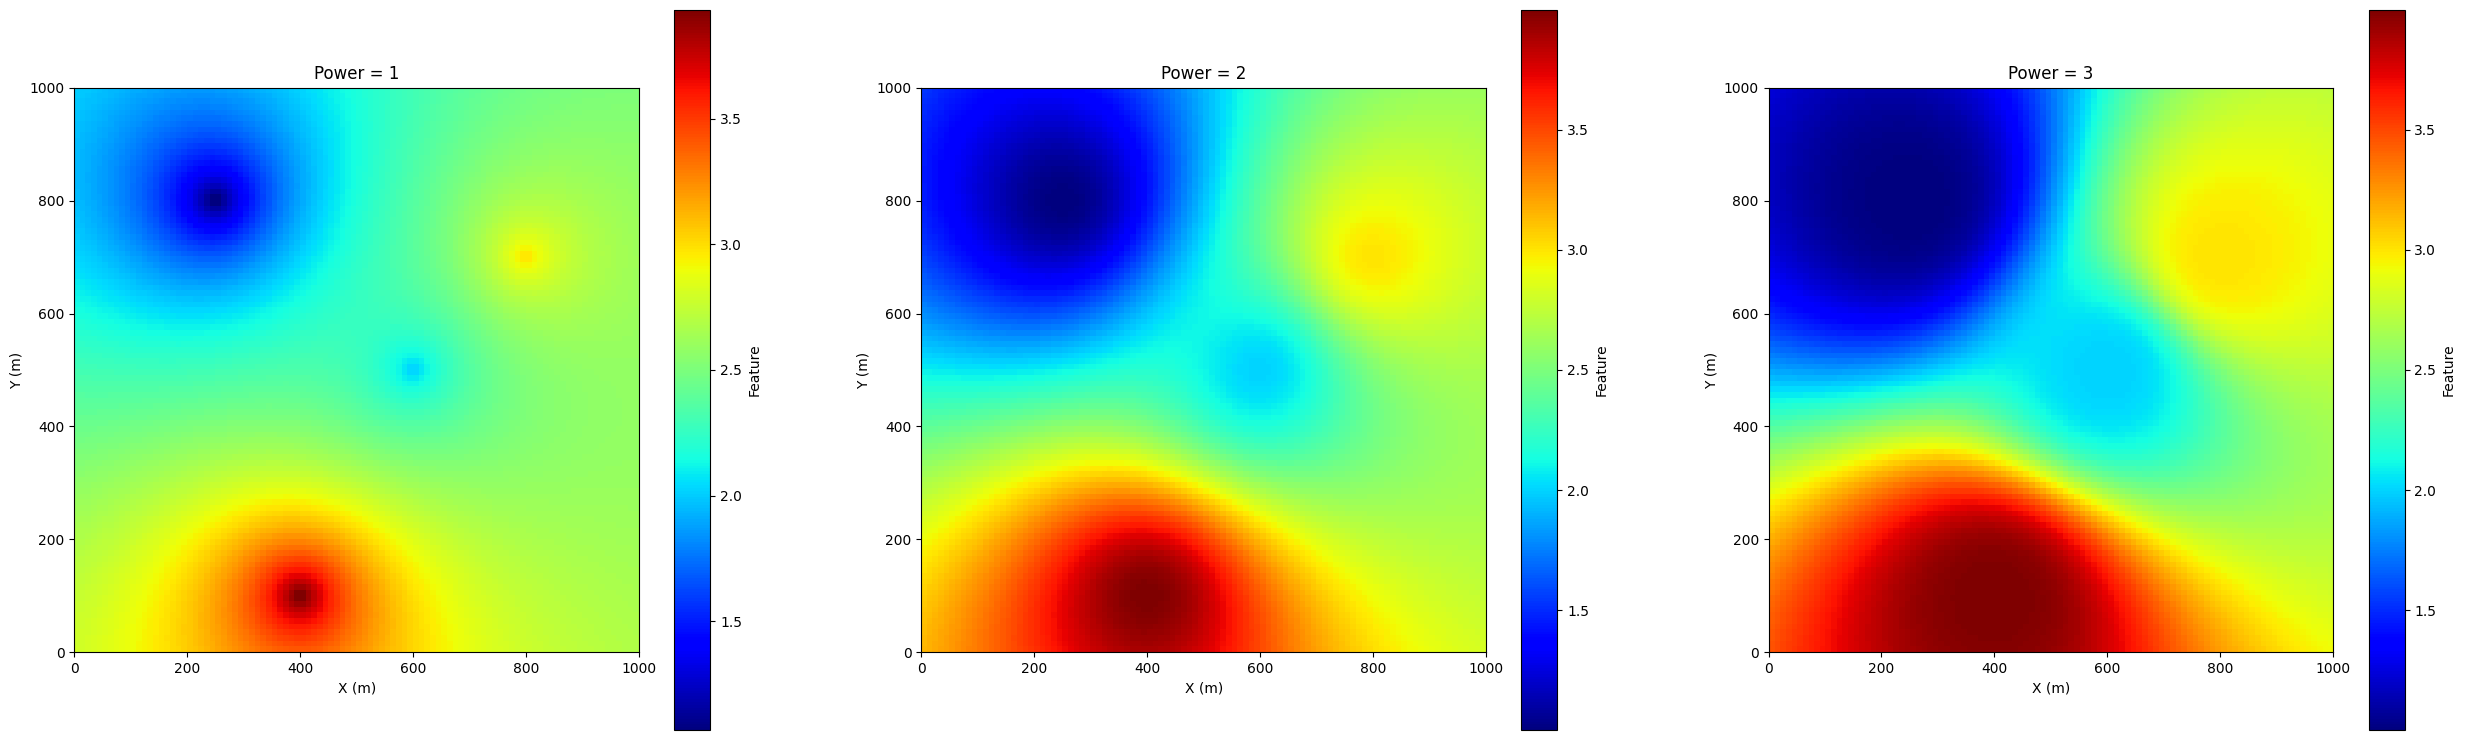

In [22]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Define the invdist function here

# Create the test DataFrame
x = [250, 600, 800, 400]
y = [800, 500, 700, 100]
vr = [1.0, 2.0, 3.0, 4.0]
dftest2 = pd.DataFrame({'X': x, 'Y': y, 'Var': vr})

# Parameters
tmin = -9999.9
tmax = 9999.9
nx = 100
xsiz = 10.0
xmn = 5.0
xmin = xmn - 0.5 * xsiz
xmax = xmin + nx * xsiz
ny = 100
ysiz = 10.0
ymn = 5.0
ymin = ymn - 0.5 * ysiz
ymax = ymin + ny * ysiz
ndmin = 1
ndmax = 100
radius = 10000.0
power = 2

# Calculate the estimated maps with different power values
invdist_map_power1 = invdist(dftest2, 'X', 'Y', 'Var', tmin, tmax, nx, xmn, xsiz, ny, ymn, ysiz, ndmin, ndmax, radius, power=1)
invdist_map_power2 = invdist(dftest2, 'X', 'Y', 'Var', tmin, tmax, nx, xmn, xsiz, ny, ymn, ysiz, ndmin, ndmax, radius, power=2)
invdist_map_power3 = invdist(dftest2, 'X', 'Y', 'Var', tmin, tmax, nx, xmn, xsiz, ny, ymn, ysiz, ndmin, ndmax, radius, power=3)

# Plot the resulting estimated maps
cmap = plt.get_cmap('jet')

plt.figure(figsize=(12, 12))

plt.subplot(131)
plt.imshow(invdist_map_power1, extent=[xmin, xmax, ymin, ymax], origin='upper', cmap=cmap)
plt.colorbar(label='Feature')
plt.title('Power = 1')
plt.xlabel('X (m)')
plt.ylabel('Y (m)')

plt.subplot(132)
plt.imshow(invdist_map_power2, extent=[xmin, xmax, ymin, ymax], origin='upper', cmap=cmap)
plt.colorbar(label='Feature')
plt.title('Power = 2')
plt.xlabel('X (m)')
plt.ylabel('Y (m)')

plt.subplot(133)
plt.imshow(invdist_map_power3, extent=[xmin, xmax, ymin, ymax], origin='upper', cmap=cmap)
plt.colorbar(label='Feature')
plt.title('Power = 3')
plt.xlabel('X (m)')
plt.ylabel('Y (m)')

plt.subplots_adjust(left=0.0, bottom=0.0, right=2.0, top=0.6, wspace=0.2, hspace=0.2)

fig_4 = plt.gcf()

plt.show()

save_fig(fig_4, 'Estimate_Maps2')

#### Check the Impact of Radius

Radius is the maximum distance to look for neighbouring data

* limited radius may result is image artifacts as data abruptly are excluded

Estimated 1264 blocks
Average 2.39116744243245  Variance 1.049982892969484
Estimated 9852 blocks
Average 1.8721620915639599  Variance 0.7914133099779668
Estimated 10000 blocks
Average 2.4797288690464803  Variance 0.5062609912988218


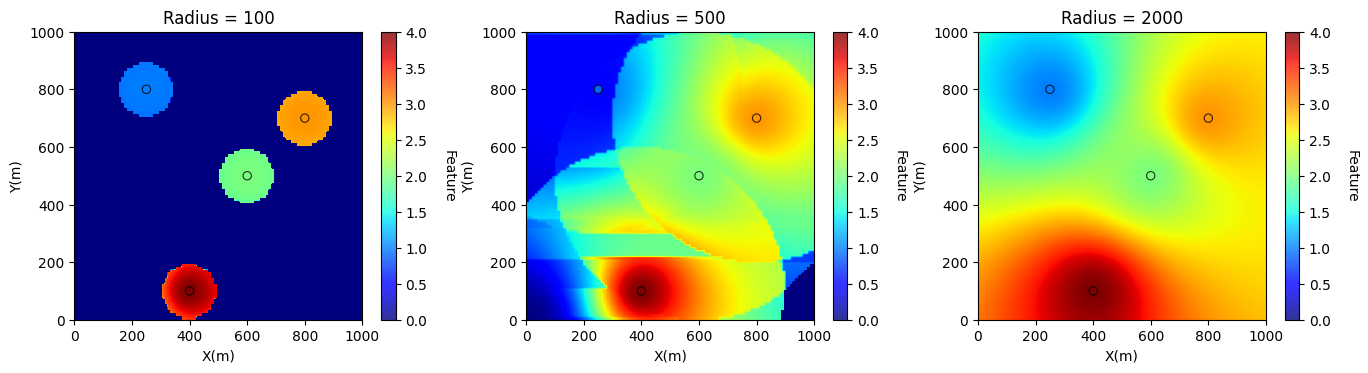

In [23]:
x = [250,600,800,400]; y = [800,500,700,100]; vr = [1.0,2.0,3.0,4.0]
dftest3 = pd.DataFrame({'X':x,'Y':y,'Var':vr})
tmin = -9999.9; tmax = 9999.9;
nx = 100; xsiz = 10.0; xmn = 5.0; xmin = xmn - 0.5 * xsiz; xmax = xmin + nx * xsiz
ny = 100; ysiz = 10.0; ymn = 5.0; ymin = ymn - 0.5 * ysiz; ymax = ymin + ny * ysiz
ndmin = 1; ndmax = 100
power = 2

invdist_map_radius1 = invdist(dftest3,'X','Y','Var',tmin,tmax,nx,xmn,xsiz,ny,ymn,ysiz,ndmin,ndmax,radius = 100,power=2)
invdist_map_radius2 = invdist(dftest3,'X','Y','Var',tmin,tmax,nx,xmn,xsiz,ny,ymn,ysiz,ndmin,ndmax,radius = 500,power=2)
invdist_map_radius3 = invdist(dftest3,'X','Y','Var',tmin,tmax,nx,xmn,xsiz,ny,ymn,ysiz,ndmin,ndmax,radius = 2000,power=2)

# plot the reuslting estimated maps
plt.subplot(131)
GSLIB.locpix_st(invdist_map_radius1,xmin,xmax,ymin,ymax,xsiz,0.0,4.0,dftest3,'X','Y','Var','Radius = 100','X(m)','Y(m)','Feature',cmap)

plt.subplot(132)
GSLIB.locpix_st(invdist_map_radius2,xmin,xmax,ymin,ymax,xsiz,0.0,4.0,dftest3,'X','Y','Var','Radius = 500','X(m)','Y(m)','Feature',cmap)

plt.subplot(133)
GSLIB.locpix_st(invdist_map_radius3,xmin,xmax,ymin,ymax,xsiz,0.0,4.0,dftest3,'X','Y','Var','Radius = 2000','X(m)','Y(m)','Feature',cmap)

plt.subplots_adjust(left=0.0, bottom=0.0, right=2.0, top=0.6, wspace=0.2, hspace=0.2)

fig_5 = plt.gcf()

plt.show()

save_fig(fig_5, 'Impact_of_Radius')

Estimated 1264 blocks
Average 2.39116744243245  Variance 1.049982892969484
Estimated 9852 blocks
Average 1.8721620915639599  Variance 0.7914133099779668
Estimated 10000 blocks
Average 2.4797288690464803  Variance 0.5062609912988218


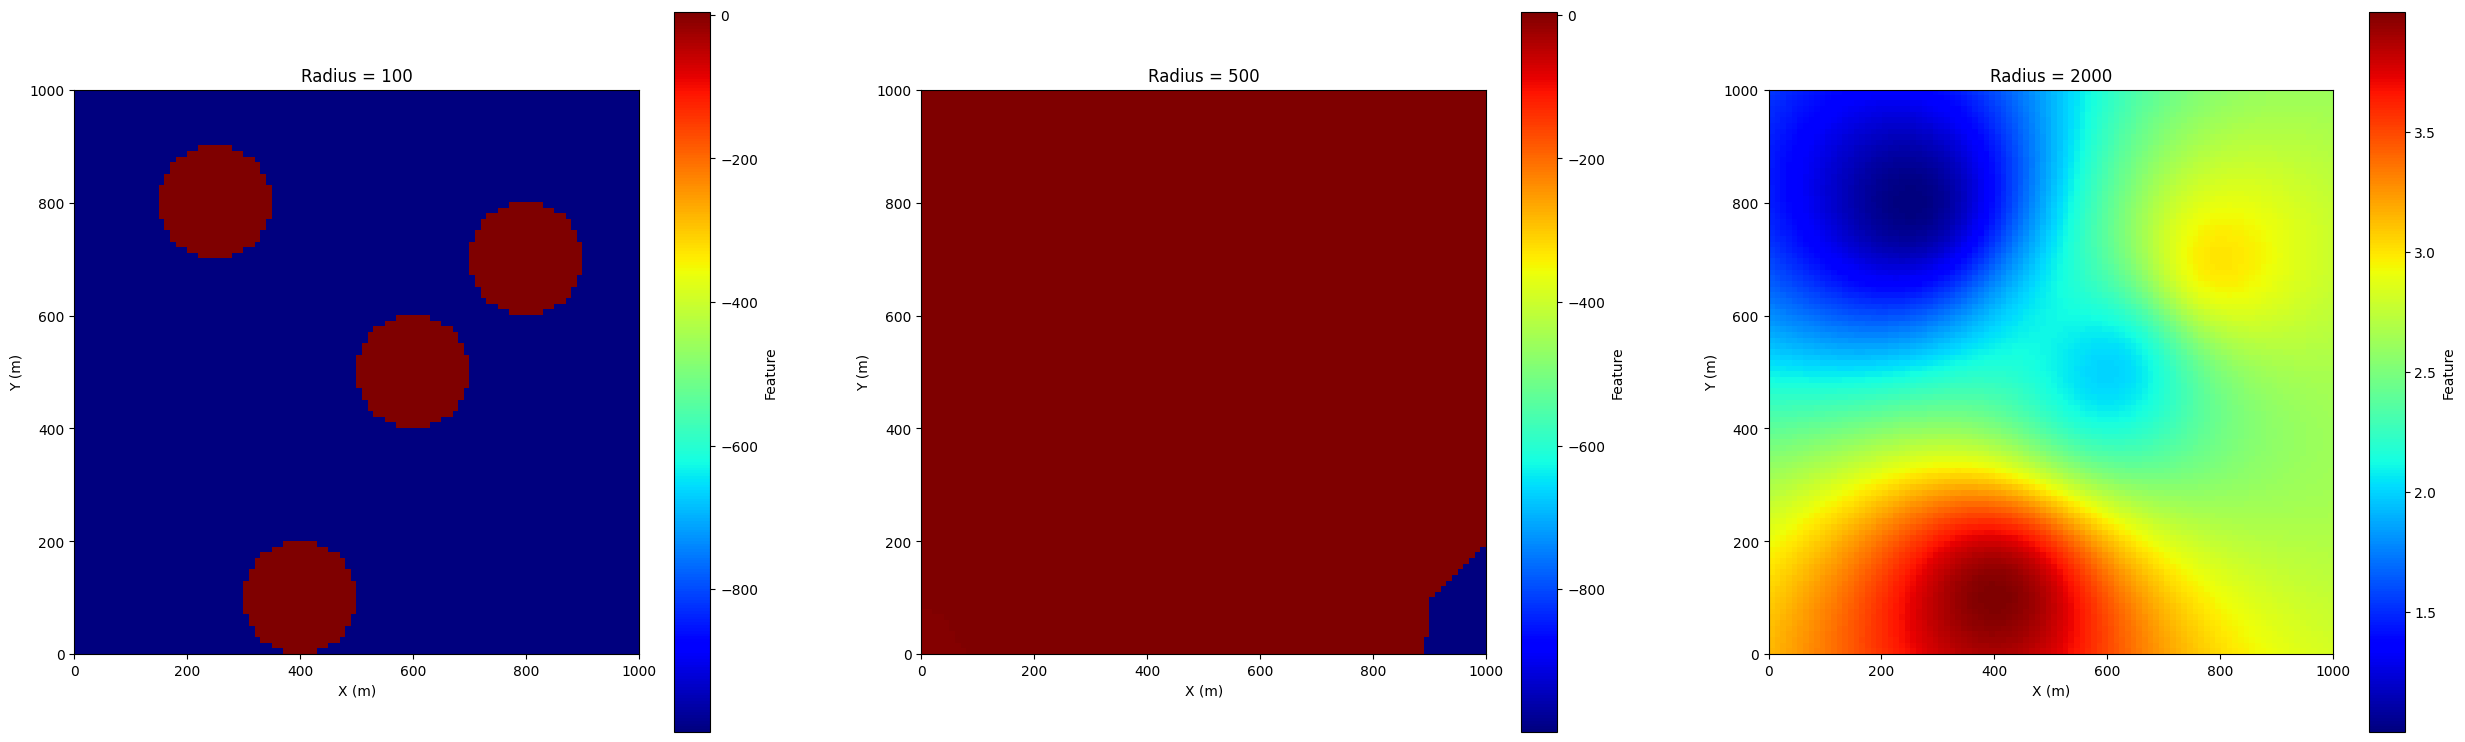

In [24]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Define the invdist function here

# Create the test DataFrame
x = [250, 600, 800, 400]
y = [800, 500, 700, 100]
vr = [1.0, 2.0, 3.0, 4.0]
dftest3 = pd.DataFrame({'X': x, 'Y': y, 'Var': vr})

# Parameters
tmin = -9999.9
tmax = 9999.9
nx = 100
xsiz = 10.0
xmn = 5.0
xmin = xmn - 0.5 * xsiz
xmax = xmin + nx * xsiz
ny = 100
ysiz = 10.0
ymn = 5.0
ymin = ymn - 0.5 * ysiz
ymax = ymin + ny * ysiz
ndmin = 1
ndmax = 100
power = 2

# Calculate the estimated maps with different radii
invdist_map_radius1 = invdist(dftest3, 'X', 'Y', 'Var', tmin, tmax, nx, xmn, xsiz, ny, ymn, ysiz, ndmin, ndmax, radius=100, power=2)
invdist_map_radius2 = invdist(dftest3, 'X', 'Y', 'Var', tmin, tmax, nx, xmn, xsiz, ny, ymn, ysiz, ndmin, ndmax, radius=500, power=2)
invdist_map_radius3 = invdist(dftest3, 'X', 'Y', 'Var', tmin, tmax, nx, xmn, xsiz, ny, ymn, ysiz, ndmin, ndmax, radius=2000, power=2)

# Plot the resulting estimated maps
cmap = plt.get_cmap('jet')

plt.figure(figsize=(12, 12))

plt.subplot(131)
plt.imshow(invdist_map_radius1, extent=[xmin, xmax, ymin, ymax], origin='upper', cmap=cmap)
plt.colorbar(label='Feature')
plt.title('Radius = 100')
plt.xlabel('X (m)')
plt.ylabel('Y (m)')

plt.subplot(132)
plt.imshow(invdist_map_radius2, extent=[xmin, xmax, ymin, ymax], origin='upper', cmap=cmap)
plt.colorbar(label='Feature')
plt.title('Radius = 500')
plt.xlabel('X (m)')
plt.ylabel('Y (m)')

plt.subplot(133)
plt.imshow(invdist_map_radius3, extent=[xmin, xmax, ymin, ymax], origin='upper', cmap=cmap)
plt.colorbar(label='Feature')
plt.title('Radius = 2000')
plt.xlabel('X (m)')
plt.ylabel('Y (m)')

plt.subplots_adjust(left=0.0, bottom=0.0, right=2.0, top=0.6, wspace=0.2, hspace=0.2)

fig_6 = plt.gcf()

plt.show()

save_fig(fig_6, 'Impact_of_Radius2')


#### Inverse Distance Porosity Map

Now we are ready to build a map of our porosity spatial feature.

* try experimenting with various powers and radii

Estimated 10000 blocks
Average 0.12259182482534683  Variance 0.0005453274134406098


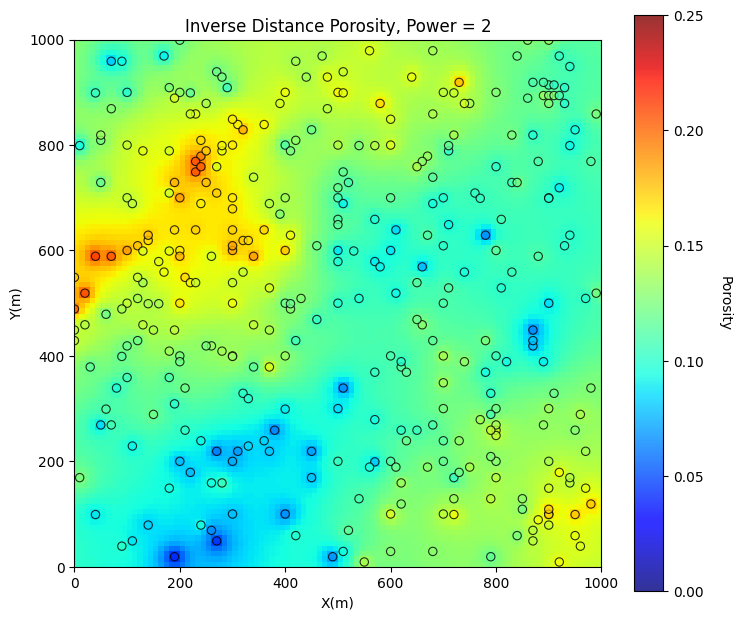

In [25]:
tmin = -9999.9; tmax = 9999.9;
nx = 100; xsiz = 10.0; xmn = 5.0; xmin = xmn - 0.5 * xsiz; xmax = xmin + nx * xsiz
ny = 100; ysiz = 10.0; ymn = 5.0; ymin = ymn - 0.5 * ysiz; ymax = ymin + ny * ysiz
ndmin = 1; ndmax = 100
radius = 2000; power = 2

invdist_map_porosity = invdist(df,'X','Y','Porosity',tmin,tmax,nx,xmn,xsiz,ny,ymn,ysiz,ndmin,ndmax,radius,power)

# plot the reuslting estimated maps
plt.subplot(131)
GSLIB.locpix_st(invdist_map_porosity,xmin,xmax,ymin,ymax,xsiz,0.0,0.25,df,'X','Y','Porosity','Inverse Distance Porosity, Power = ' + str(power),'X(m)','Y(m)','Porosity',cmap)

plt.subplots_adjust(left=0.0, bottom=0.0, right=3.5, top=1.2, wspace=0.2, hspace=0.2)

fig_7 = plt.gcf()

plt.show()

save_fig(fig_7, 'Inverse Distance Porosity Map')

Estimated 10000 blocks
Average 0.12259182482534683  Variance 0.0005453274134406098


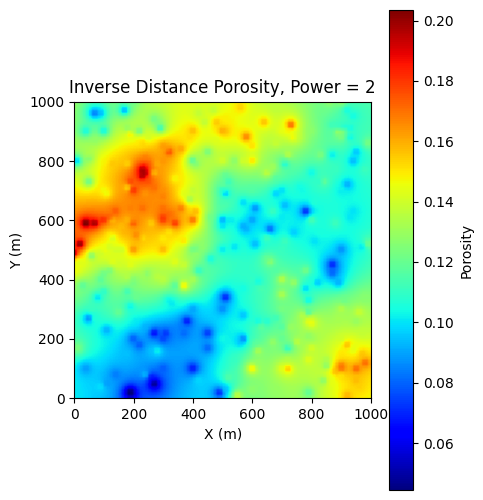

In [26]:
import matplotlib.pyplot as plt
import numpy as np

# Parameters
tmin = -9999.9
tmax = 9999.9
nx = 100
xsiz = 10.0
xmn = 5.0
xmin = xmn - 0.5 * xsiz
xmax = xmin + nx * xsiz
ny = 100
ysiz = 10.0
ymn = 5.0
ymin = ymn - 0.5 * ysiz
ymax = ymin + ny * ysiz
ndmin = 1
ndmax = 100
radius = 2000
power = 2

# Calculate the estimated map
invdist_map_porosity = invdist(df, 'X', 'Y', 'Porosity', tmin, tmax, nx, xmn, xsiz, ny, ymn, ysiz, ndmin, ndmax, radius, power)

# Plot the resulting estimated map
plt.figure(figsize=(14, 6))
plt.subplot(131)
plt.imshow(invdist_map_porosity, extent=[xmin, xmax, ymin, ymax], origin='upper', cmap='jet')
plt.colorbar(label='Porosity')
plt.title('Inverse Distance Porosity, Power = ' + str(power))
plt.xlabel('X (m)')
plt.ylabel('Y (m)')

plt.subplots_adjust(left=0.05, bottom=0.1, right=0.95, top=0.9, wspace=0.2, hspace=0.2)

fig_8 = plt.gcf()

plt.show()

save_fig(fig_8, 'Inverse Distance Porosity Map__2')


In [27]:
invdist_map_porosity

array([[0.12766458, 0.12555326, 0.12308179, ..., 0.11404383, 0.11410626,
        0.11426359],
       [0.12667087, 0.12427111, 0.12126225, ..., 0.11321299, 0.11354544,
        0.11382204],
       [0.12593547, 0.12318579, 0.11979691, ..., 0.11248765, 0.11301333,
        0.11342699],
       ...,
       [0.10091095, 0.10006266, 0.09930923, ..., 0.15173147, 0.15058871,
        0.14948949],
       [0.1009384 , 0.10018818, 0.09945335, ..., 0.15048922, 0.14959496,
        0.14865381],
       [0.1010234 , 0.10029987, 0.09958187, ..., 0.14926902, 0.14856695,
        0.14777946]])

# Question 3: IDW Estimation and Export

In [29]:
# Parameters for the  IDW
tmin = -9999.9; tmax = 9999.9
nx = 100; xmn = 5.0; xsiz = 10.0
ny = 100; ymn = 5.0; ysiz = 10.0
ndmin = 1; ndmax = 100; radius = 2000

# IDW estimate for power 2
power = 2
invdist_map_porosity_p2 = invdist(df, 'X', 'Y', 'Porosity', tmin, tmax, nx, xmn, xsiz, ny, ymn, ysiz, ndmin, ndmax, radius, power)

# IDW estimate for power 3
power = 3
invdist_map_porosity_p3 = invdist(df, 'X', 'Y', 'Porosity', tmin, tmax, nx, xmn, xsiz, ny, ymn, ysiz, ndmin, ndmax, radius, power)


Estimated 10000 blocks
Average 0.12259182482534683  Variance 0.0005453274134406098
Estimated 10000 blocks
Average 0.12116877653698746  Variance 0.0007154759122327669


In [30]:
# Flatten results to create a tabular format for export
X_flat = np.repeat(np.arange(xmn, xmn + nx * xsiz, xsiz), ny)  ## create an array of x-coordinates
Y_flat = np.tile(np.arange(ymn, ymn + ny * ysiz, ysiz), nx)    ##creates an array of y-coordinates

Porosity_p2_flat = invdist_map_porosity_p2.flatten(order='F')  # Flatten in Fortran (column-major) order
Porosity_p3_flat = invdist_map_porosity_p3.flatten(order='F')

In [31]:
# Create DataFrames for the results
results_p2 = pd.DataFrame({'X': X_flat, 'Y': Y_flat, 'Porosity': Porosity_p2_flat})
results_p3 = pd.DataFrame({'X': X_flat, 'Y': Y_flat, 'Porosity': Porosity_p3_flat})

In [35]:
# Save the results into the 'results' file
results_p2.to_csv('Results/idw_porosity_p2.csv', index=False)
results_p3.to_csv('Results/idw_porosity_p3.csv', index=False)

# Question 4: Import and Scatter Plot

In [38]:
d1 = pd.read_csv('Results/idw_porosity_p2.csv')                     # read a .csv file in as a DataFrame
d2 = pd.read_csv('Results/idw_porosity_p3.csv')

In [39]:
d1.head()

,X,Y,Porosity
0,5.0,5.0,0.127665
1,5.0,15.0,0.126671
2,5.0,25.0,0.125935
3,5.0,35.0,0.125541
4,5.0,45.0,0.125310


In [40]:
d2.head()

,X,Y,Porosity
0,5.0,5.0,0.109385
1,5.0,15.0,0.108288
2,5.0,25.0,0.107686
3,5.0,35.0,0.107666
4,5.0,45.0,0.108144


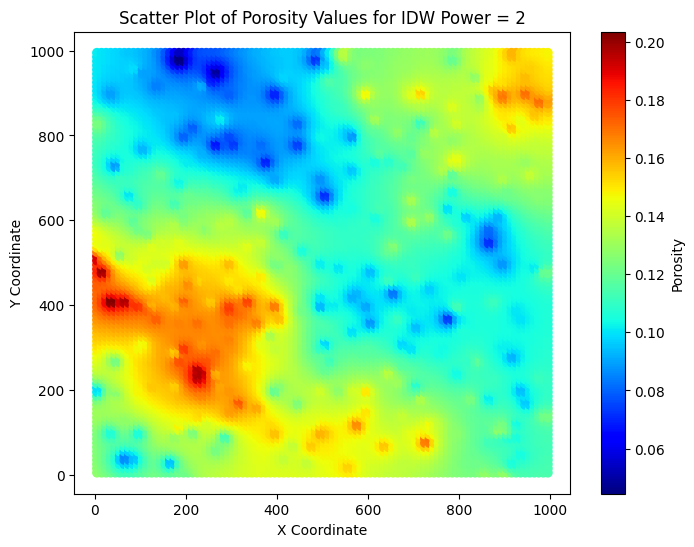

In [46]:
# For Power 2 Satter Plot

plt.figure(figsize=(8,6))

scatter_p2 = plt.scatter(d1['X'], d1['Y'], c = d1['Porosity'], cmap = 'jet')
plt.colorbar(label='Porosity')

plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.title('Scatter Plot of Porosity Values for IDW Power = 2')

fig_9 = plt.gcf()
plt.show()

save_fig(fig_9, ' Q4- Inverse Distance Porosity Power = 2')

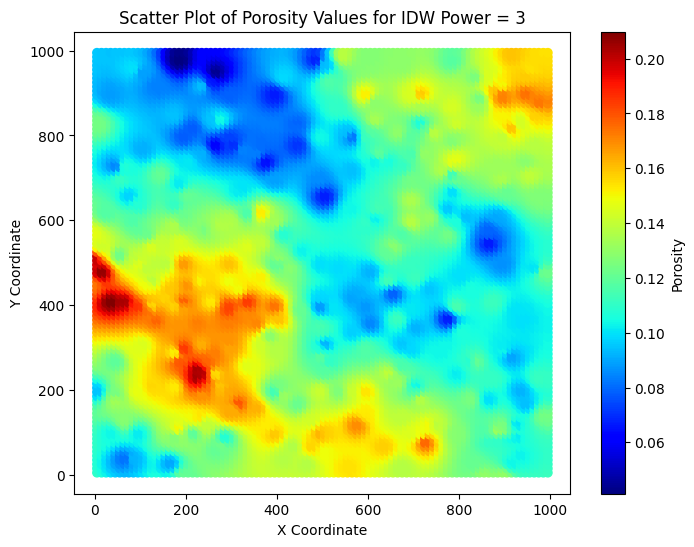

In [47]:
# For Power 3 Satter Plot

plt.figure(figsize=(8,6))

scatter_p3 = plt.scatter(d2['X'], d2['Y'], c = d2['Porosity'], cmap = 'jet')
plt.colorbar(label='Porosity')

plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.title('Scatter Plot of Porosity Values for IDW Power = 3')

fig_10 = plt.gcf()
plt.show()

save_fig(fig_10, ' Q4- Inverse Distance Porosity Power = 3')



---
**END**








